<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8153 entries, 0 to 8152
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   country                       8153 non-null   object        
 1   location_name                 8153 non-null   object        
 2   latitude                      8153 non-null   float64       
 3   longitude                     8153 non-null   float64       
 4   timezone                      8153 non-null   object        
 5   last_updated_epoch            8153 non-null   int64         
 6   last_updated                  8153 non-null   datetime64[ns]
 7   temperature_celsius           8153 non-null   float64       
 8   temperature_fahrenheit        8153 non-null   float64       
 9   condition_text                8153 non-null   object        
 10  wind_mph                      8153 non-null   float64       
 11  wind_kph                      

<ipython-input-1-b9c2b457638c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


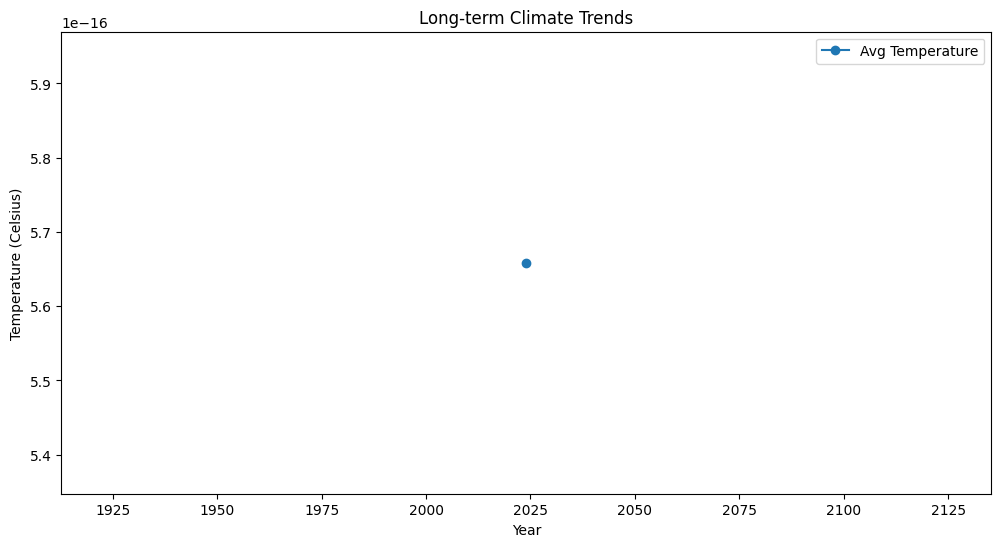

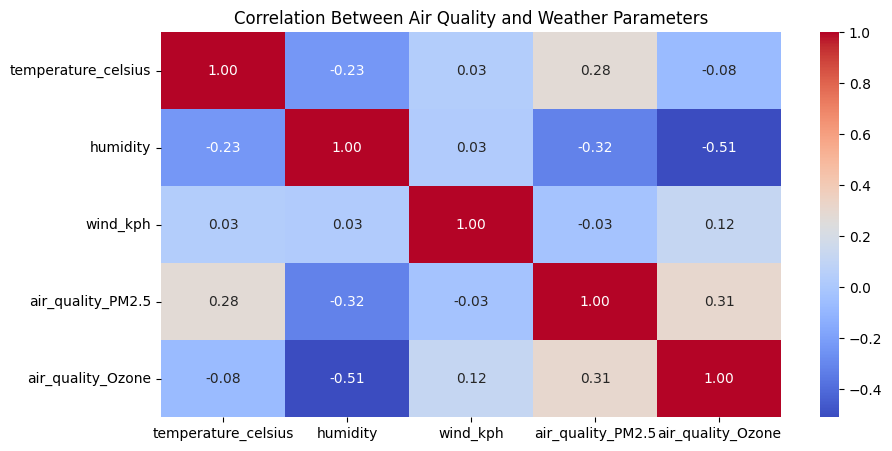

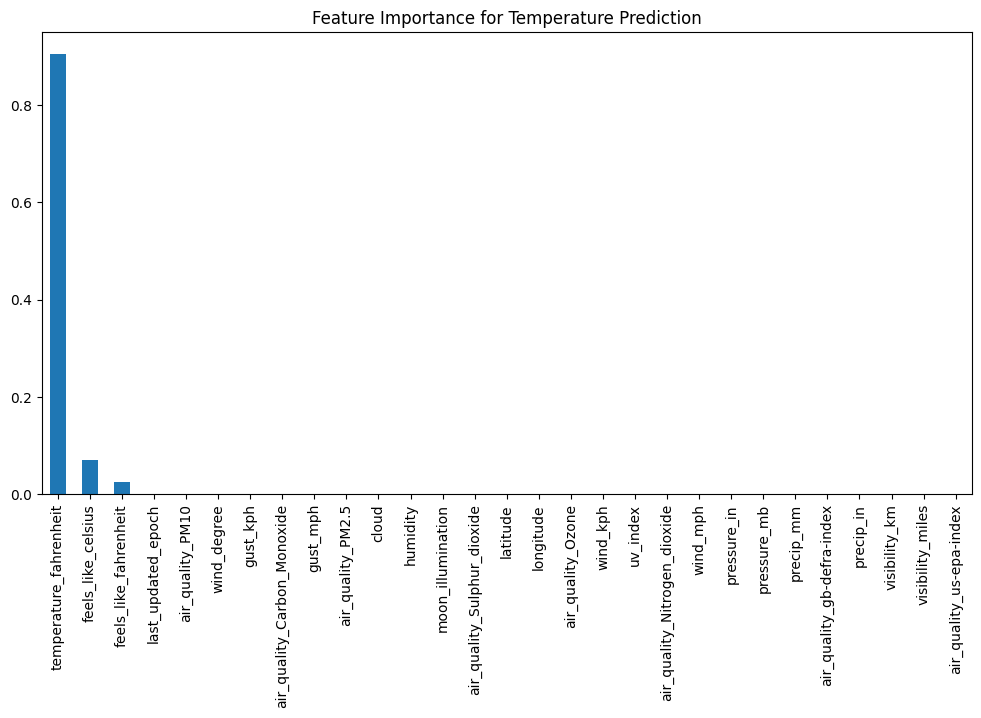

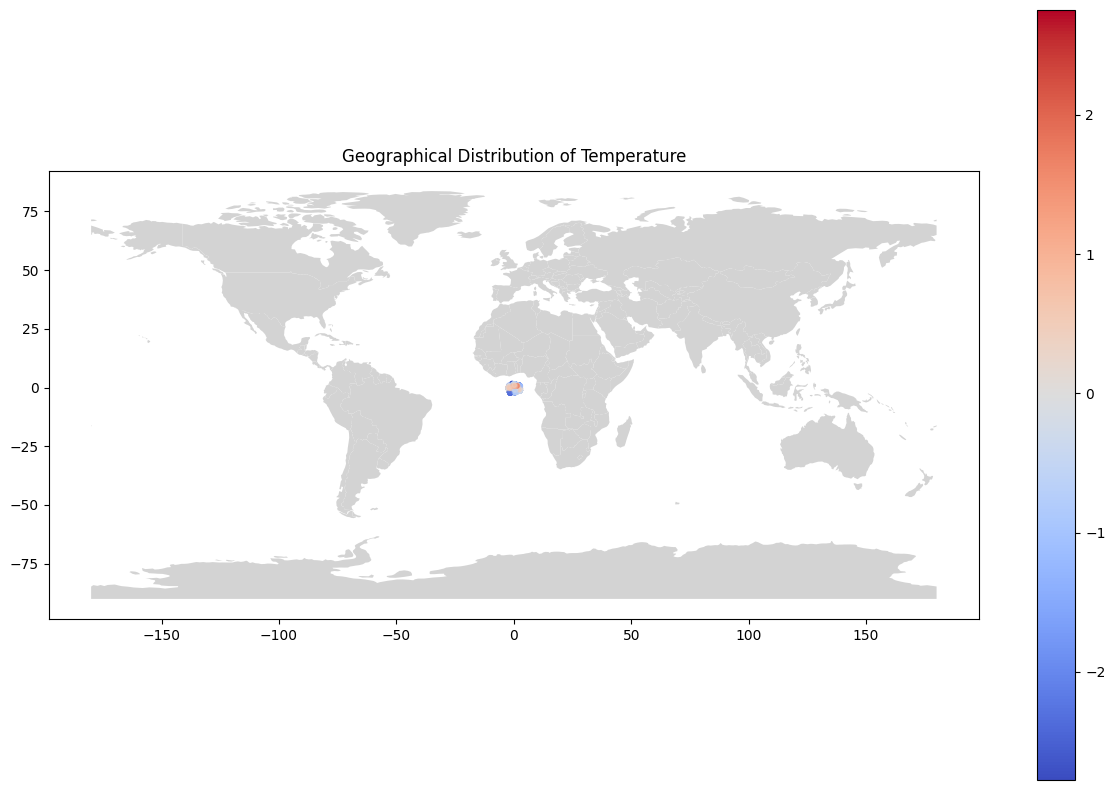

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

ARIMA - MAE: 0.8766596984825724, MSE: 1.1414332739791957
Exponential Smoothing - MAE: 0.7954222469806602, MSE: 0.972803309577858
Linear Regression - MAE: 0.7902934540069583, MSE: 0.9679099186579583
Ensemble - MAE: 0.8091097191813698, MSE: 0.9936469351621634


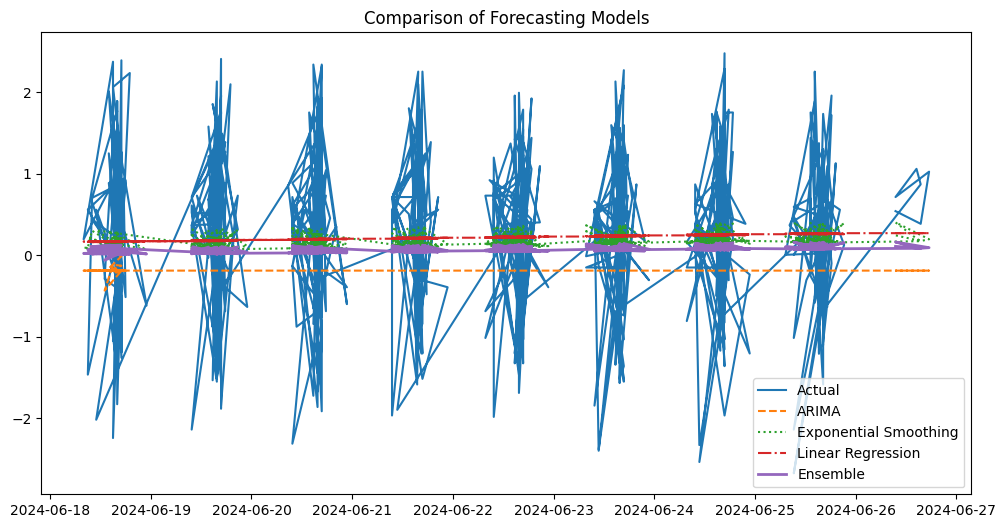

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

# Load Dataset
df = pd.read_csv('GlobalWeatherRepository.csv', parse_dates=['last_updated'])

# Inspect Data
print(df.info())
print(df.describe())
print(df.head())

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Handle Missing Values
# Apply median only to numeric columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
# Fill categorical missing values with mode
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Handle Outliers using IQR
q1 = df[numeric_cols].quantile(0.25)
q3 = df[numeric_cols].quantile(0.75)
iqr = q3 - q1
df = df[~((df[numeric_cols] < (q1 - 1.5 * iqr)) | (df[numeric_cols] > (q3 + 1.5 * iqr))).any(axis=1)]

# Normalize Data
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso_forest.fit_predict(df[numeric_cols])

# Climate Analysis - Study long-term patterns
df['year'] = df['last_updated'].dt.year
df_grouped = df.groupby('year')[numeric_cols].mean()
plt.figure(figsize=(12,6))
plt.plot(df_grouped.index, df_grouped['temperature_celsius'], marker='o', label='Avg Temperature')
plt.title('Long-term Climate Trends')
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.show()

# Environmental Impact - Correlation between air quality and weather parameters
plt.figure(figsize=(10, 5))
sns.heatmap(df[['temperature_celsius', 'humidity', 'wind_kph', 'air_quality_PM2.5', 'air_quality_Ozone']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Air Quality and Weather Parameters')
plt.show()

# Feature Importance Analysis
rf = RandomForestRegressor()
x = df[numeric_cols].drop(columns=['temperature_celsius'])
y = df['temperature_celsius']
rf.fit(x, y)
feature_importance = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance for Temperature Prediction')
plt.show()

# Spatial Analysis - Visualizing temperature variations by location
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/110m_cultural/ne_110m_admin_0_countries.shp")  # Ensure this file is in your working directory
fig, ax = plt.subplots(figsize=(15,10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, column='temperature_celsius', cmap='coolwarm', legend=True, markersize=10, alpha=0.5)
plt.title('Geographical Distribution of Temperature')
plt.show()

# Time Series Forecasting Models
df.set_index('last_updated', inplace=True)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# ARIMA Model
arima_model = ARIMA(train['temperature_celsius'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_predictions = arima_fit.forecast(steps=len(test))

# Exponential Smoothing Model
exp_model = ExponentialSmoothing(train['temperature_celsius'], trend='add', seasonal='add', seasonal_periods=12)
exp_fit = exp_model.fit()
exp_predictions = exp_fit.forecast(steps=len(test))

# Linear Regression Model
linear_model = LinearRegression()
time_index = np.arange(len(train)).reshape(-1, 1)
time_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
linear_model.fit(time_index, train['temperature_celsius'])
linear_predictions = linear_model.predict(time_test)

# Ensemble Model (Averaging Predictions)
ensemble_predictions = (arima_predictions + exp_predictions + linear_predictions) / 3

# Evaluate Models
models = {'ARIMA': arima_predictions, 'Exponential Smoothing': exp_predictions, 'Linear Regression': linear_predictions, 'Ensemble': ensemble_predictions}
for model_name, preds in models.items():
    mae = mean_absolute_error(test['temperature_celsius'], preds)
    mse = mean_squared_error(test['temperature_celsius'], preds)
    print(f'{model_name} - MAE: {mae}, MSE: {mse}')

# Visualization of Forecasting
plt.figure(figsize=(12,6))
plt.plot(test.index, test['temperature_celsius'], label='Actual')
plt.plot(test.index, arima_predictions, label='ARIMA', linestyle='dashed')
plt.plot(test.index, exp_predictions, label='Exponential Smoothing', linestyle='dotted')
plt.plot(test.index, linear_predictions, label='Linear Regression', linestyle='dashdot')
plt.plot(test.index, ensemble_predictions, label='Ensemble', linestyle='solid', linewidth=2)
plt.legend()
plt.title('Comparison of Forecasting Models')
plt.show()